<h1>SMBCグループ GREEN×DATA チャレンジ2024</h1>
<p>
SMBCグループ GREEN×DATA チャレンジ2024にご参加いただき、ありがとうございます。<br>
このチュートリアルでは、予測アルゴリズムを作成し、投稿ファイルを作る方法を<a href="https://colab.research.google.com/">Google Colaboratory（以下、Colab）</a>で説明します。<br>
Colabは、ブラウザでPythonプログラミングができる無料サービスで、利用にはGoogleアカウントが必要です。<br>
Colabでは、準備された分析環境をそのまま使えるので、初心者でも環境構築をスキップできます。
</p>
<p>
チュートリアルの後は、このコードを基に精度を上げてみてください。<br>
また、このチュートリアルで使うNotebookは「データ」ページからダウンロードできます。<br>
皆様のたくさんの投稿をお待ちしております！
</p>

<h2>目次</h2>

1. イントロダクション
2. 前処理
3. 予測モデルの学習・検証
4. 予測結果の投稿
5. 精度改善のヒント

# 1.イントロダクション

## 1-1.Colabの使用方法
<p>以下では、Colabの起動からGoogle Drive内のデータ読み込むための準備の手順を説明します。</p>

<h3>Colabの起動</h3>

1. Googleアカウントにログイン
2. ブラウザで <a href="https://colab.research.google.com/">Colab</a> にアクセス
3. 「新しいノートブック」をクリックして、新しいColab環境を立ち上げる

<h3>Google Driveのディレクトリ構成</h3>
<p>
今回はマイドライブの中に、以下のような構造でデータを置くことを前提とします。
</p>

```sh
マイドライブ/
├── data/
│   ├── train.csv
│   ├── test.csv
│   ├── sample_submission.csv
│   └── tutorial.ipynb
```

<h3>Google Driveへの接続方法</h3>

1. Colabノートブックを開いた状態で、以下のコードを実行して自分のGoogle Driveへ接続

In [265]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. 「Google Driveに接続」をクリックし、Googleアカウントを選択
3. 接続が成功すると、「Mounted at /content/drive」というメッセージが表示される
<p>
これで、自分のGoogle Drive に接続できました!<br>
以下のコードでマイドライブの中にあるフォルダを確認することもできます。
</p>

In [266]:
ls /content/drive/MyDrive/

 atmacup10/           Jリーグ/     Pycaret本/              松尾研/
'Colab Notebooks'/    kaggle/      signate/                機械学習26/
'Google AI Studio'/   oputuna本/   大規模言語モデル入門/


## 1-2.ライブラリの読み込み

ライブラリを読み込むことで、pythonがある特定の分野に特化した処理を行うことができるようになります。<br>
データ分析を行うための基本的なライブラリを読み込みましょう。<br>
今使用するライブラリの全てを読み込まなくても、必要に応じて都度ライブラリを読み込みながら進めることもできます。

In [267]:
# 基本的なライブラリは、Colabではデフォルトで利用可能

import pandas as pd               # データを表のように扱うライブラリ
import numpy as np                # 数値計算を速くするライブラリ
import seaborn as sns             # きれいなグラフを簡単に作るライブラリ
import matplotlib.pyplot as plt   # グラフを作る基本的なライブラリ
%matplotlib inline

from sklearn.model_selection import train_test_split  # データを訓練用と検証用に分ける
from sklearn.metrics import mean_squared_log_error # 評価の計算を行うライブラリ
import lightgbm as lgb # 予測モデルに関するライブラリ

import warnings
warnings.simplefilter('ignore')  # 不要な警告を表示しない

<h2> 1-3.データの読み込み</h2>

<p>それではデータを読み込んでみましょう。<br>
データを読み込むには pd.read_csv() を使います。<br>
マイドライブは/content/drive/の中にあるので、trainデータまでのパスは以下のようになります。</p>

In [268]:
path  = "/content/drive/My Drive/signate/SMBC Group GREEN×DATA Challenge 2024/"
# 予測モデルを訓練するためのデータセット
train = pd.read_csv(path+'train.csv', index_col=0)

# 予測モデルに推論（予測)させるデータセット
test = pd.read_csv(path+'test.csv', index_col=0)

In [269]:
# すべての列を表示するように設定
pd.set_option('display.max_columns', None)
train

,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
0,VISCOFAN USA INC,40.141389,-87.581111,915 N MICHIGAN AVE,DANVILLE,IL,61832,VERMILION,17183.0,326121,NaN,Other,31566.709644,26644.986107,23410.379903,31809.857564,64816.958901,36588.744606,3.790794e+04,45598.125851,5.297314e+04
1,"CORNWELL STATION - DOMINION TRANSMISSION, INC",38.475305,-81.278957,200 RIVER HAVEN ROAD,CLENDENIN,WV,25045-9304,KANAWHA,54039.0,486210,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,55507.543666,72387.334115,5.822520e+04,76376.547318,5.591007e+04
2,WEST UNION COMPRESSOR STATION,39.299820,-80.857170,3041 LONG RUN RD.,GREENWOOD,WV,26415,RITCHIE,54085.0,211112,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.567954e+04
3,"DOUBLE ""C"" LIMITED",35.490363,-119.042957,10245 OILFIELD ROAD,BAKERSFIELD,CA,93308,KERN,6029.0,221112,NaN,Power Plants,NaN,NaN,NaN,NaN,54811.222708,69339.923002,6.364734e+04,53799.011225,6.141190e+04
4,LAKESHORE PLANT,41.532802,-81.636448,6800 S MARGINAL RD,CLEVELAND,OH,441031047,CUYAHOGA,39035.0,221112,NaN,Power Plants,29553.796627,28337.832145,30840.825454,25153.901905,81812.306362,53823.561587,7.739116e+04,17662.966241,4.310047e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,MIDLOTHIAN COMPRESSOR STATION,32.523334,-97.102556,2624 CHAMBERS ST.,VENUS,TX,76084,JOHNSON,48251.0,211111,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,54978.841280,56463.765036,3.522786e+06,76642.640670,2.451197e+06
4651,PARADISE COMPRESSOR STATION,42.684900,-109.780000,"SECTION 2, T31N, R109W",PINEDALE,WY,82941,SUBLETTE,56035.0,211111,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,208375.435367,57066.624445,4.858030e+04,26892.366779,3.573974e+04
4652,UNIV OF OK HEALTH S/OKC CAMPUS SVCS,35.484260,-97.498570,800 NE 15TH ST,OKLAHOMA CITY,OK,73104,OKLAHOMA,40109.0,611310,NaN,Other,NaN,NaN,NaN,NaN,563756.090695,598881.479485,1.665103e+06,543206.073134,9.783592e+05
4653,HARFORD CO. RESOURCE RECOVERY FACILITY,39.404310,-76.319820,1 MAGNOLIA ROAD,JOPPA,MD,21085-4800,HARFORD,24025.0,562213,NaN,Waste,NaN,NaN,NaN,NaN,67451.225733,27397.929966,3.922795e+04,46634.777768,2.723434e+04


これでデータを読み込むことができました！次章ではどのようなデータがそれぞれに格納されているのかを確認します。

# 2.前処理  


AIモデルが正確に予測できるということは、入力データの特徴量と予測したい結果（目的変数）の関係をよく理解している状態です。しかし、AIモデルがどんなに優秀でも、すべての入力データで自動的にその関係を見つけられるわけではありません。<br>つまり、AIモデルがその関係を理解しやすくするためには、モデルを訓練する前に入力データを**適切に加工（前処理）**する必要があります。
<br>
適切な加工を実施するために、以下の2ステップを説明いたします。
1. データのことを調べて、どのような処理が必要か考えてみる
2. 考えた処理を実際に実装してみる

これらのステップで「入力データから目的変数の情報をどれだけ効果的に引き出せるか」は予測性能の高いAIモデルを作るために最も重要な処理の一つです。

そこで、まず始めに訓練用データの中身を確かめてみましょう。

In [270]:
def describe_data(data, name):
    print(f"\n{name} のデータ概要:\n")
    display(data.info())
    display(data.describe())

describe_data(train, 'train')

describe_data(test, 'test')


train のデータ概要:

<class 'pandas.core.frame.DataFrame'>
Index: 4655 entries, 0 to 4654
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   FacilityName                            4655 non-null   object 
 1   Latitude                                4553 non-null   float64
 2   Longitude                               4553 non-null   float64
 3   LocationAddress                         4476 non-null   object 
 4   City                                    4655 non-null   object 
 5   State                                   4655 non-null   object 
 6   ZIP                                     4655 non-null   object 
 7   County                                  4585 non-null   object 
 8   FIPScode                                4582 non-null   float64
 9   PrimaryNAICS                            4655 non-null   int64  
 10  SecondPrimaryNAICS                      379 non-n

None

,Latitude,Longitude,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
count,4553.000000,4553.000000,4582.000000,4655.000000,379.000000,1.635000e+03,1635.000000,1635.000000,1635.000000,3.953000e+03,4.284000e+03,4.395000e+03,4.507000e+03,4.655000e+03
mean,37.502474,-93.132567,29594.314055,354701.002578,320797.759894,6.179064e+04,43853.462331,53770.293062,56007.086034,2.485158e+05,1.612068e+05,3.159905e+05,1.834006e+05,2.525133e+05
std,5.739955,15.680084,16565.382504,145549.947021,36638.391132,1.344983e+05,55988.952050,93977.128341,109863.242856,5.225110e+05,2.641831e+05,7.395843e+05,4.026237e+05,4.854669e+05
min,13.394900,-166.553496,1001.000000,111419.000000,212113.000000,2.279515e+03,34.450512,2076.649083,4656.522747,1.089413e+02,8.167190e-01,2.009966e+02,2.689283e+01,5.598067e+02
25%,33.471611,-98.498664,17105.500000,221112.000000,322121.000000,2.525215e+04,25319.052605,22764.672344,22905.881327,5.123975e+04,3.733935e+04,4.822487e+04,3.547781e+04,4.174869e+04
50%,37.873810,-90.446667,29034.000000,325180.000000,325199.000000,3.204187e+04,31765.719617,29667.091832,29305.093678,7.440347e+04,6.119749e+04,7.242684e+04,5.744658e+04,6.789793e+04
75%,41.152783,-82.604399,45050.000000,486210.000000,331111.000000,4.019123e+04,38329.096290,36984.431956,36755.017845,1.676409e+05,1.418608e+05,2.279668e+05,1.195544e+05,2.109168e+05
max,70.490861,144.807727,78010.000000,928110.000000,562212.000000,1.251231e+06,478366.459152,743548.788013,989230.802586,3.900222e+06,2.698567e+06,6.837260e+06,4.330236e+06,4.614103e+06



test のデータ概要:

<class 'pandas.core.frame.DataFrame'>
Index: 2508 entries, 4655 to 7162
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   FacilityName                            2508 non-null   object 
 1   Latitude                                2452 non-null   float64
 2   Longitude                               2452 non-null   float64
 3   LocationAddress                         2395 non-null   object 
 4   City                                    2508 non-null   object 
 5   State                                   2508 non-null   object 
 6   ZIP                                     2508 non-null   object 
 7   County                                  2463 non-null   object 
 8   FIPScode                                2463 non-null   float64
 9   PrimaryNAICS                            2508 non-null   int64  
 10  SecondPrimaryNAICS                      184 non

None

,Latitude,Longitude,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons
count,2452.000000,2452.000000,2463.000000,2508.000000,184.000000,8.740000e+02,874.000000,874.000000,8.740000e+02,2.130000e+03,2.297000e+03,2.371000e+03,2.435000e+03
mean,37.570662,-92.363851,30404.922452,354306.630383,318199.500000,6.487513e+04,40970.199510,49969.490551,5.099979e+04,2.567106e+05,1.601432e+05,3.124102e+05,1.892745e+05
std,5.758665,15.263442,16241.454602,147092.064447,48626.377425,1.532609e+05,50742.809398,96607.925446,1.092213e+05,5.239007e+05,2.753633e+05,7.448045e+05,4.284521e+05
min,13.463579,-158.125764,1001.000000,211111.000000,115114.000000,4.405829e+03,5343.548842,3144.557141,1.221438e+03,1.342263e+02,5.203845e+01,3.003952e+03,2.226384e+02
25%,33.139870,-97.758778,17200.000000,221112.000000,322130.000000,2.465727e+04,25406.683554,23070.544500,2.206082e+04,5.025370e+04,3.543934e+04,4.570376e+04,3.507816e+04
50%,38.047855,-90.131700,31067.000000,325155.000000,325199.000000,3.137226e+04,30861.833946,29153.614011,2.811996e+04,7.313435e+04,5.862897e+04,6.998558e+04,5.659606e+04
75%,41.346859,-81.908218,47032.000000,486210.000000,331111.000000,3.898384e+04,37976.075558,35656.637976,3.498953e+04,1.850996e+05,1.138890e+05,2.150169e+05,1.113874e+05
max,71.292071,144.678216,78030.000000,928110.000000,562910.000000,1.374503e+06,481505.852810,898432.732339,1.010902e+06,3.927869e+06,2.120411e+06,6.112087e+06,4.292472e+06


データの中身を確認しました。<br>
今回目的変数は施設ごとの2014年のGHG排出量(GHG_Direct_Emissions_14_in_metric_tonsReviewer_Score)です。<br>
特徴量は、施設の場所や業種といったカテゴリデータと観測値の数字データがあります。<br>
また、Non-Null Countを見るといくつか欠損値が含まれていることもわかります。

前処理の方法は以下が挙げられます。
1. カテゴリ型（str）
  - 場所を表すデータは場所別に特徴がないかを確認しグルーピング
  - IndustryTypeで特徴に差があるかを確認してエンコーディング
2. 数値型（int, float）
  - 欠損値の処理
  - 分布を確認して標準化など

それでは実際に確認していきましょう。

## 2-1.カテゴリ型（str）の処理

#### 場所を表す特徴量

緯度（Latitude）経度（Longitude）の情報から地図上にマッピングしてみましょう。<br>
それだけでなく、目的変数である2014年のGHG排出量の大小で色分けもしてみます。<br>
難しいかつ、使用頻度が高くないコードですので、覚えずに生成AIを活用してください！

In [271]:
# import folium
# import matplotlib.cm as cm
# import matplotlib.colors as colors
# from IPython.display import display

# # 必要なデータを抽出し、新しいデータフレームを作成
# data = train[['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons']].copy()

# # 緯度、経度、排出量のいずれかが欠損している行を削除
# data.dropna(subset=['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons'], inplace=True)

# # 各列のデータ型を float に変換
# for col in ['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons']:
#     data[col] = data[col].astype(float)

# # 地図の中心をデータの緯度と経度の平均位置に設定
# map_center = [data['Latitude'].mean(), data['Longitude'].mean()]
# m = folium.Map(location=map_center, zoom_start=5)

# # 排出量の最大値と最小値を取得
# max_emission = data['GHG_Direct_Emissions_14_in_metric_tons'].max()
# min_emission = data['GHG_Direct_Emissions_14_in_metric_tons'].min()

# # カラーマップを設定（排出量が少ない地点は黄色、多い地点は赤色で表示）
# colormap = cm.get_cmap('YlOrRd')
# normalize = colors.Normalize(vmin=min_emission, vmax=max_emission)

# # 各地点に対して、排出量に応じた色の円マーカーを作成し地図に追加
# for idx, row in data.iterrows():
#     # 排出量に基づいて色を設定
#     color = colors.rgb2hex(colormap(normalize(row['GHG_Direct_Emissions_14_in_metric_tons'])))

#     # 円マーカーを作成
#     folium.CircleMarker(
#         location=[row['Latitude'], row['Longitude']],  # 緯度・経度
#         radius=5,  # 円のサイズ
#         popup=f"Emissions: {row['GHG_Direct_Emissions_14_in_metric_tons']}",  # ポップアップに排出量を表示
#         color=color,  # 枠の色
#         fill=True,  # 円を塗りつぶす
#         fill_color=color  # 塗りつぶしの色
#     ).add_to(m)

# # 地図を表示（Jupyter Notebook 上で表示可能）
# display(m)


ブラウザ上では表示できませんが、マウス操作で動かせるマップに、データ内で相対的に数値が高いところは赤くそうでないところは黄色く表示されます。<br>
ぜひご自身のノートブックで表示して考察してみてください。

#### 業種を表す特徴量

業種とGHG排出量はなんらかの関係があると仮説を立てることができます。業種を表すIndustryTypeを確認してみましょう。

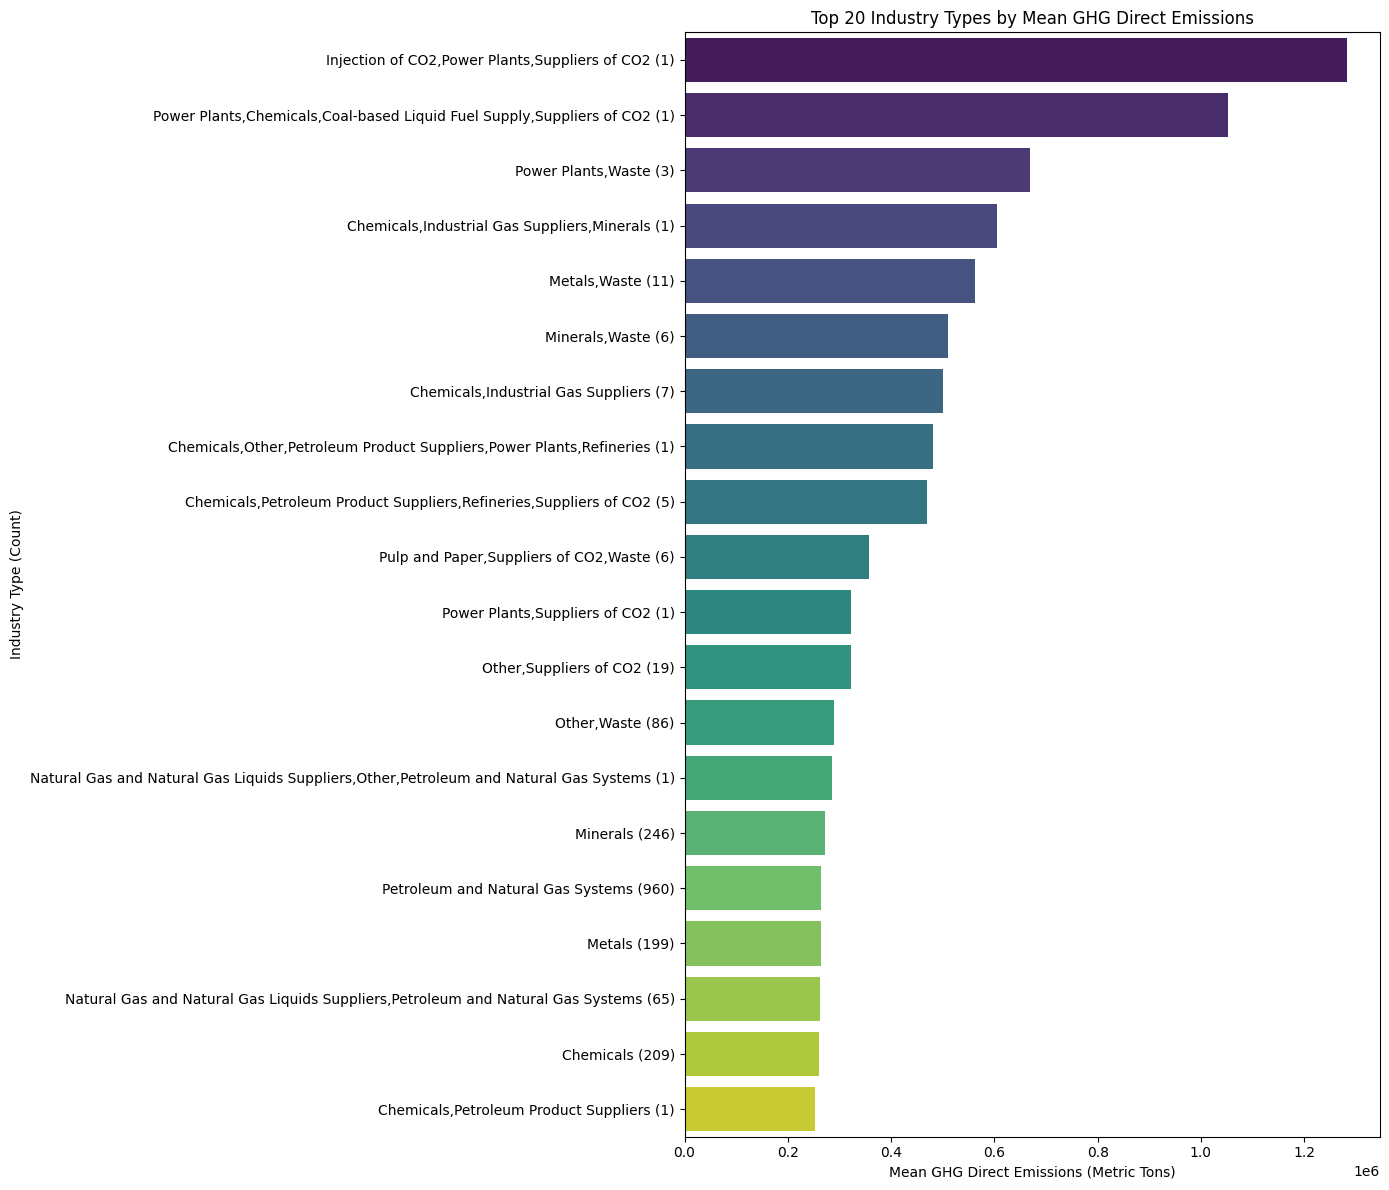

In [272]:
# 1. 産業タイプごとの平均GHG排出量を計算
ghg_by_industry = train.groupby('IndustryType')['GHG_Direct_Emissions_14_in_metric_tons'].mean().reset_index()

# 2. 産業タイプごとのデータ数を計算
count_by_industry = train['IndustryType'].value_counts().reset_index()
count_by_industry.columns = ['IndustryType', 'Count']

# 3. 平均GHG排出量とデータ数をマージ
ghg_with_count = pd.merge(ghg_by_industry, count_by_industry, on='IndustryType')

# 4. 排出量が多い順にソート
ghg_with_count = ghg_with_count.sort_values(by='GHG_Direct_Emissions_14_in_metric_tons', ascending=False)

# 5. 上位20の産業タイプを選択
ghg_top20 = ghg_with_count.head(20)

# 6. 産業タイプ名にデータ数を追加
ghg_top20['IndustryType_with_Count'] = ghg_top20.apply(
    lambda row: f"{row['IndustryType']} ({row['Count']})",
    axis=1
)

# 7. プロットの作成
plt.figure(figsize=(14, 12))
sns.barplot(
    data=ghg_top20,
    y='IndustryType_with_Count',
    x='GHG_Direct_Emissions_14_in_metric_tons',
    palette='viridis'
)
plt.title('Top 20 Industry Types by Mean GHG Direct Emissions')
plt.xlabel('Mean GHG Direct Emissions (Metric Tons)')
plt.ylabel('Industry Type (Count)')
plt.tight_layout()
plt.show()

排出量上位を占めている産業に関してはその産業数が少ない傾向にあるのでラベルコーディングをしても、スコアが向上しない。

In [273]:
# 1. データの結合
all_x = pd.concat([train, test], ignore_index=True)

# 2. 出現回数のカウント
industry_counts = all_x['IndustryType'].value_counts()

# 3. 低頻度カテゴリの特定と置換
# 出現回数が9以下のカテゴリを 'Other' に置き換え
low_freq_categories = industry_counts[industry_counts <= 9].index
all_x['IndustryType'] = all_x['IndustryType'].replace(low_freq_categories, 'Other')

# 4. ダミー変数化
all_x = pd.get_dummies(all_x, columns=['IndustryType'])

# 5. データの分割
train_processed = all_x.iloc[:len(train)].reset_index(drop=True)
test_processed = all_x.iloc[len(train):].reset_index(drop=True)

# 必要に応じて元の変数名に戻す
train = train_processed
test = test_processed

In [274]:
train.shape, test.shape

((4655, 41), (2508, 41))

思いのほか、多くの要素がありました。<br>
今回は実施しませんが、これらのカテゴリを数値化する手法としてエンコーディングというものがあります。<br>

<hr>

`参考`<br>
**エンコーディングとは何か**

エンコーディングとは、AIモデルが理解できるように、文字やカテゴリなどの非数値データを数値データに変換することです。これにより、AIモデルはデータを適切に処理し、学習することができます。<br>
以下は代表的なエンコーディング手法である「ラベルエンコーディング」と「ワンホットエンコーディング」を整理した表です。<br>
<br>

| 項目 | **ラベルエンコーディング** | **ワンホットエンコーディング** |
| --- | --- | --- |
| **手法** | カテゴリを整数値に変換する。<br>例:「赤」=0、「青」=1、「緑」=2 | 各カテゴリごとに新しい二進数の特徴量を作成する。<br>例:「赤」=[1,0,0]、「青」=[0,1,0]、「緑」=[0,0,1] |
| **メリット** | - シンプルで実装が容易<br> | - カテゴリ間の関係性を持たない<br>- モデルがカテゴリを平等に扱う |
| **デメリット** | - カテゴリに順位がないのに数値が割り当てられるため、モデルが誤解する可能性がある | - データの次元数が増加し、高次元になると計算量が増える |
| **選択基準** | - カテゴリに明確な順位や大小関係がある場合 | - カテゴリに順位がない場合<br>- カテゴリ数が多すぎない場合 |


<hr>

## 2-2.数値型（int, float）の処理

続いて数値型の前処理です。<br>
まずは可視化して分布を確認します。

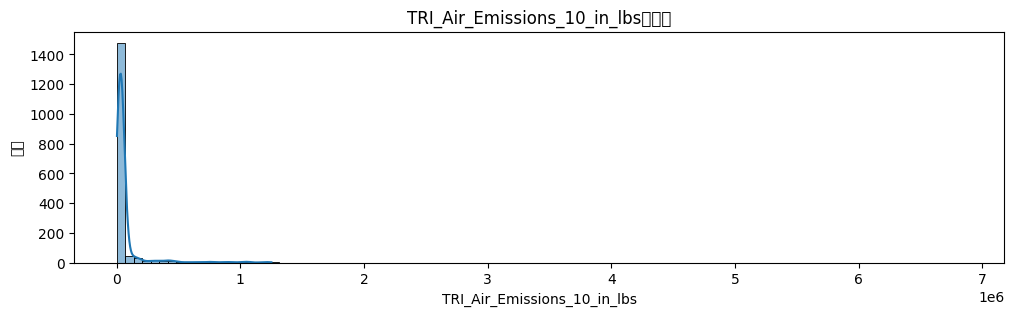

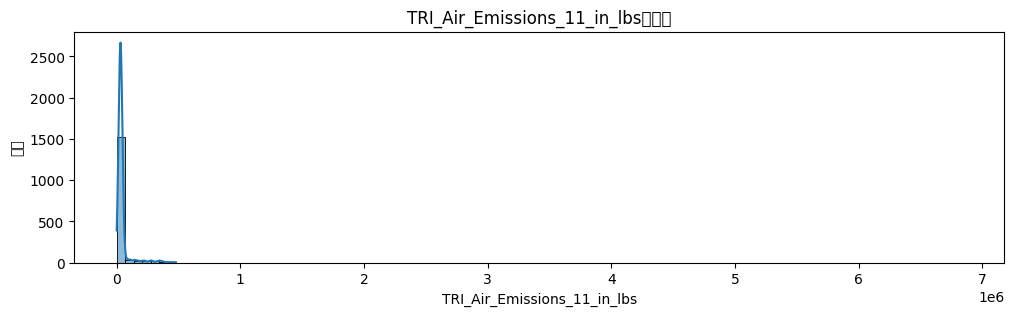

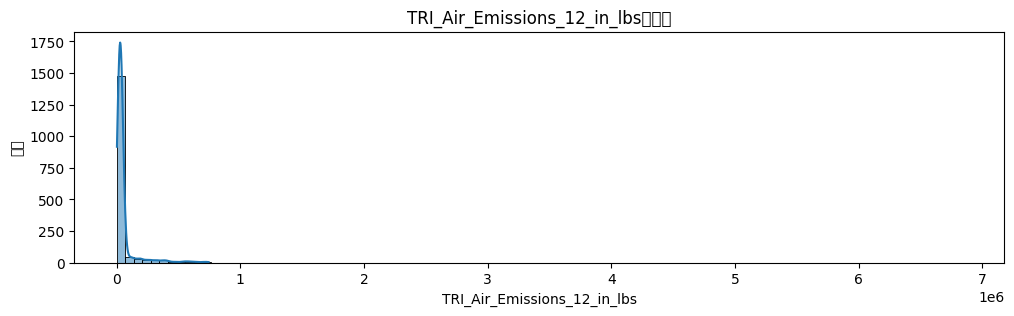

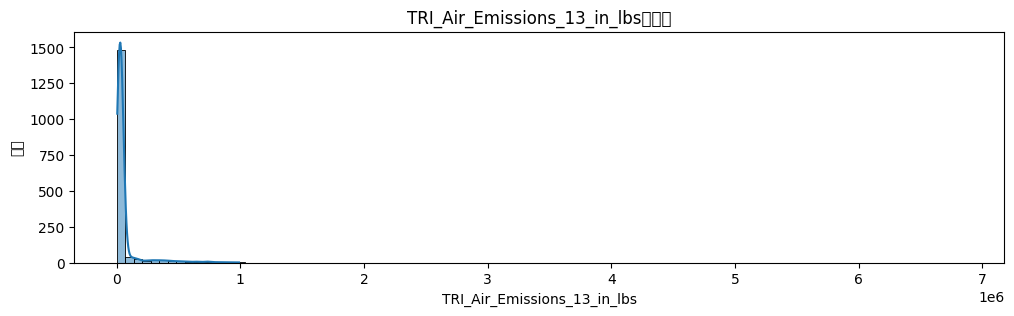

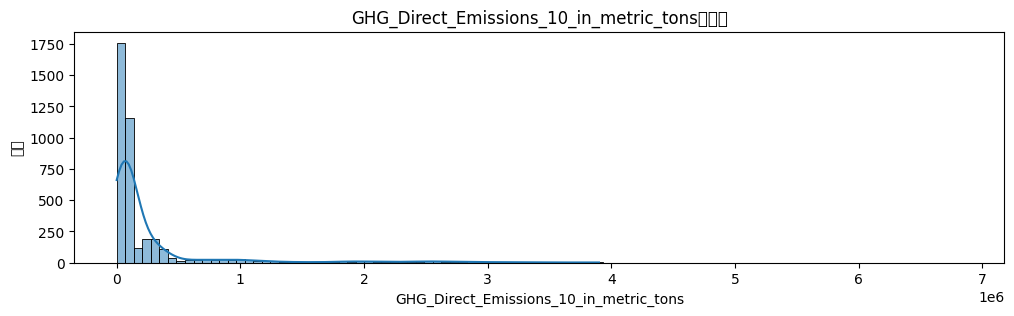

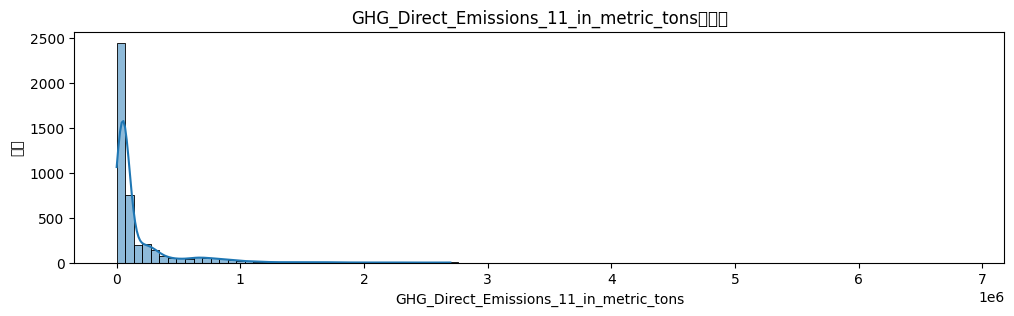

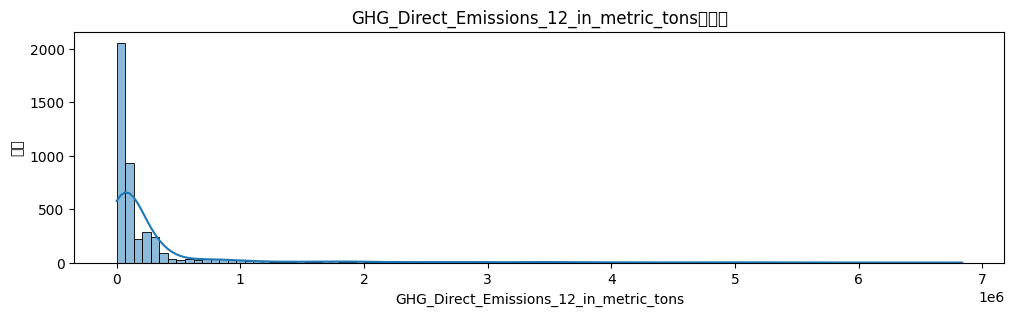

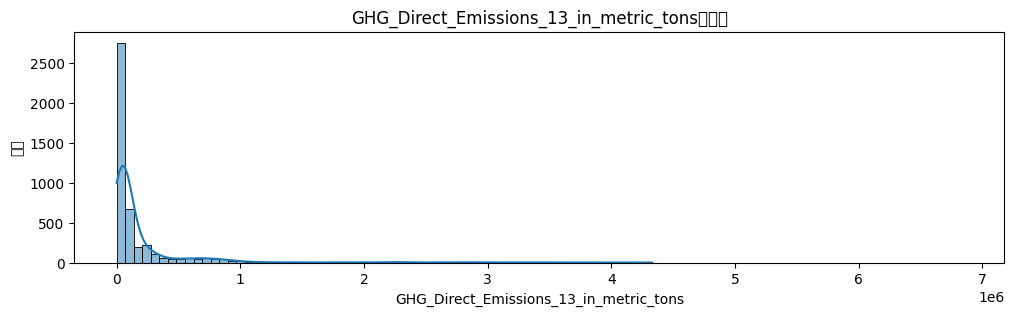

In [275]:
numerical_features = [
    'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
    'GHG_Direct_Emissions_10_in_metric_tons', 'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons',
    ]

num_bins = 100
min_value = train[numerical_features].min().min()
max_value = train[numerical_features].max().max()
bins = np.linspace(min_value, max_value, num_bins)

for col in numerical_features:
    plt.figure(figsize=(12, 3))
    sns.histplot(train[col], bins=bins, kde=True)
    plt.title(f'{col}の分布')
    plt.xlabel(col)
    plt.ylabel('頻度')
    plt.show()
    print()

すべての数値データが小さな値に偏っており、各特徴量の数値の範囲に多少差があります。<br>
このような偏った分布では、平均値が大きくなりやすいため、欠損値は**中央値**で補います。<br>
すごい大きな値のデータも存在はしている

In [276]:
# 欠損値の補完
for col in numerical_features:
    train[col].fillna(train[col].median(), inplace=True)
    test[col].fillna(train[col].median(), inplace=True)

## 中央値以外での欠損値処理に関しても検討してみる価値あり。

以上で前処理は終了です。<br>
今回は数値データのみを利用してAIモデルを構築します。

In [277]:
test

,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons,IndustryType_Chemicals,"IndustryType_Chemicals,Industrial Gas Suppliers","IndustryType_Chemicals,Petroleum Product Suppliers,Refineries","IndustryType_Chemicals,Suppliers of CO2","IndustryType_Chemicals,Waste",IndustryType_Metals,"IndustryType_Metals,Waste",IndustryType_Minerals,"IndustryType_Minerals,Waste","IndustryType_Natural Gas and Natural Gas Liquids Suppliers,Petroleum and Natural Gas Systems",IndustryType_Other,"IndustryType_Other,Suppliers of CO2","IndustryType_Other,Suppliers of CO2,Waste","IndustryType_Other,Waste","IndustryType_Petroleum Product Suppliers,Refineries",IndustryType_Petroleum and Natural Gas Systems,IndustryType_Power Plants,IndustryType_Pulp and Paper,"IndustryType_Pulp and Paper,Waste",IndustryType_Refineries,IndustryType_Waste
0,ROGER AOTSCHEGAROW,38.033040,-97.973170,1910 SOUTH BROADACRES ROAD,HUTCHINSON,KS,67501,RENO,20155.0,211112,NaN,32041.869853,31765.719617,29667.091832,29305.093678,88951.390376,65803.021457,2.899329e+04,32965.487915,NaN,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,EPNG STATION 6543 LORDSBURG,32.316030,-108.606800,NaN,LORDSBURG,NM,88045,HIDALGO,35023.0,486210,NaN,32041.869853,31765.719617,29667.091832,29305.093678,74403.471971,61197.487743,3.119260e+05,268668.069110,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,OWENS-BROCKWAY GLASS CONTAINER INC PLANT 19,41.251500,-78.742440,3831 ROUTE 219,BROCKPORT,PA,15823,JEFFERSON,42065.0,327213,NaN,28275.061385,32075.140635,26445.792090,23385.161510,84908.372871,6212.899604,3.473291e+04,39045.247387,NaN,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,WALDORF CORP (DBA ROCKTENN),44.959660,-93.193410,2250 WABASH AVE,SAINT PAUL,MN,551141895,RAMSEY,27123.0,322130,NaN,37330.205714,42503.897432,43906.102080,42958.306538,49004.603631,52.038452,1.426237e+04,20204.924986,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,SOLAR TURBINES INC KEARNY MESA,32.818720,-117.125800,4200 RUFFIN RD MZ T-2,SAN DIEGO,CA,92123,SAN DIEGO,6073.0,333611,NaN,45310.722699,39897.800897,40203.428231,39437.099224,84959.769922,15351.359676,4.000654e+04,63935.249120,NaN,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,BEULAH SANITARY LANDFILL,38.651945,-75.914445,ROUTE 331 & ROUTE 16- BEULAH ROAD,HURLOCK,MD,21643,DORCHESTER,24019.0,562212,NaN,32041.869853,31765.719617,29667.091832,29305.093678,110523.066755,98954.793233,3.467008e+06,147802.356027,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2504,SONORA GAS PLANT,31.361795,-101.776403,NaN,RANKIN,TX,79778,UPTON,48461.0,211112,NaN,32041.869853,31765.719617,29667.091832,29305.093678,74403.471971,61197.487743,7.242684e+04,57446.583282,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2505,ASH GROVE CEMENT CO,41.005565,-96.154917,16215 HWY 50,LOUISVILLE,NE,680372881,CASS,31025.0,327310,NaN,22956.125554,23592.402994,25069.498286,24560.172725,166520.232511,469732.826538,8.255855e+04,85775.307

In [278]:
test

,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons,IndustryType_Chemicals,"IndustryType_Chemicals,Industrial Gas Suppliers","IndustryType_Chemicals,Petroleum Product Suppliers,Refineries","IndustryType_Chemicals,Suppliers of CO2","IndustryType_Chemicals,Waste",IndustryType_Metals,"IndustryType_Metals,Waste",IndustryType_Minerals,"IndustryType_Minerals,Waste","IndustryType_Natural Gas and Natural Gas Liquids Suppliers,Petroleum and Natural Gas Systems",IndustryType_Other,"IndustryType_Other,Suppliers of CO2","IndustryType_Other,Suppliers of CO2,Waste","IndustryType_Other,Waste","IndustryType_Petroleum Product Suppliers,Refineries",IndustryType_Petroleum and Natural Gas Systems,IndustryType_Power Plants,IndustryType_Pulp and Paper,"IndustryType_Pulp and Paper,Waste",IndustryType_Refineries,IndustryType_Waste
0,ROGER AOTSCHEGAROW,38.033040,-97.973170,1910 SOUTH BROADACRES ROAD,HUTCHINSON,KS,67501,RENO,20155.0,211112,NaN,32041.869853,31765.719617,29667.091832,29305.093678,88951.390376,65803.021457,2.899329e+04,32965.487915,NaN,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,EPNG STATION 6543 LORDSBURG,32.316030,-108.606800,NaN,LORDSBURG,NM,88045,HIDALGO,35023.0,486210,NaN,32041.869853,31765.719617,29667.091832,29305.093678,74403.471971,61197.487743,3.119260e+05,268668.069110,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,OWENS-BROCKWAY GLASS CONTAINER INC PLANT 19,41.251500,-78.742440,3831 ROUTE 219,BROCKPORT,PA,15823,JEFFERSON,42065.0,327213,NaN,28275.061385,32075.140635,26445.792090,23385.161510,84908.372871,6212.899604,3.473291e+04,39045.247387,NaN,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,WALDORF CORP (DBA ROCKTENN),44.959660,-93.193410,2250 WABASH AVE,SAINT PAUL,MN,551141895,RAMSEY,27123.0,322130,NaN,37330.205714,42503.897432,43906.102080,42958.306538,49004.603631,52.038452,1.426237e+04,20204.924986,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,SOLAR TURBINES INC KEARNY MESA,32.818720,-117.125800,4200 RUFFIN RD MZ T-2,SAN DIEGO,CA,92123,SAN DIEGO,6073.0,333611,NaN,45310.722699,39897.800897,40203.428231,39437.099224,84959.769922,15351.359676,4.000654e+04,63935.249120,NaN,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,BEULAH SANITARY LANDFILL,38.651945,-75.914445,ROUTE 331 & ROUTE 16- BEULAH ROAD,HURLOCK,MD,21643,DORCHESTER,24019.0,562212,NaN,32041.869853,31765.719617,29667.091832,29305.093678,110523.066755,98954.793233,3.467008e+06,147802.356027,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2504,SONORA GAS PLANT,31.361795,-101.776403,NaN,RANKIN,TX,79778,UPTON,48461.0,211112,NaN,32041.869853,31765.719617,29667.091832,29305.093678,74403.471971,61197.487743,7.242684e+04,57446.583282,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2505,ASH GROVE CEMENT CO,41.005565,-96.154917,16215 HWY 50,LOUISVILLE,NE,680372881,CASS,31025.0,327310,NaN,22956.125554,23592.402994,25069.498286,24560.172725,166520.232511,469732.826538,8.255855e+04,85775.307

# 3. 予測モデルの学習・検証


本章ではモデルの学習と検証を行います。

そこでまず、次の操作を行います。
1. 学習用データセットに含まれる特徴量と目的変数の分離
2. 学習用データセットを学習用と検証用のデータセットへ分割

In [279]:
import re

def sanitize_column_names(df):
    sanitized_columns = []
    for col in df.columns:
        # 特殊文字をアンダースコアに置換
        sanitized_col = re.sub(r'[^a-zA-Z0-9_]', '_', col)
        # 連続するアンダースコアを単一に
        sanitized_col = re.sub(r'_+', '_', sanitized_col)
        # 先頭または末尾のアンダースコアを削除
        sanitized_col = sanitized_col.strip('_')
        sanitized_columns.append(sanitized_col)
    df.columns = sanitized_columns
    return df

# train と test の列名をサニタイズ
train = sanitize_column_names(train)
test = sanitize_column_names(test)


In [280]:
# 訓練用データセットからターゲットを分離する
X = train.iloc[:, 11:]
X.drop(columns=['GHG_Direct_Emissions_14_in_metric_tons'], inplace=True)
y = train['GHG_Direct_Emissions_14_in_metric_tons']

# 投稿のためのテストデータも同様の処理を行う
test_X = test.iloc[:, 11:]
test_X.drop(columns=['GHG_Direct_Emissions_14_in_metric_tons'], inplace=True)
# 訓練用データセットを訓練用と検証用に分割する
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 結果の確認（データフレームの形状）
print(f"X_train: {X_train.shape}, X_valid: {X_valid.shape}")
print(f"y_train: {y_train.shape}, y_valid: {y_valid.shape}")

X_train: (3724, 29), X_valid: (931, 29)
y_train: (3724,), y_valid: (931,)


In [281]:
X
test_X.shape

(2508, 29)

## 3-1. 今回使用する予測モデルの紹介

次に利用する予測モデルを用意します。表データ用の予測モデルを構築する手法は数多く提案されていますが、本チュートリアルでは、その中でも最も有名で強力な手法の一つである**LightGBM**を利用します。<br>
かいつまんだ説明にはなりますが、この手法では以下の工夫により、高速に予測能力の高いモデルの構築を実現しています。

1. 内部に持つ複数の予測器のアンサンブルによる精度の高い予測（キーワード：勾配ブースティング法, アンサンブル学習）
2. 情報の少ない列をまとめて扱うことによる高速な訓練（キーワード：Exclusive Feature Bundling）

次節ではLightGBMを使った学習を行います。

## 3-2. 学習

In [282]:
# LightGBM用のデータセットに変換
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

# LightGBMのパラメータ設定
params = {
    'objective': 'regression',  # 回帰タスク
    'metric': 'rmse',  # RMSEで評価
    'boosting_type': 'gbdt',  # 勾配ブースティング木
    'learning_rate': 0.1,  # 学習率
    'verbose': -1,  # 詳細な出力を抑制
    'random_state':42 # 乱数の固定
}

# モデルの訓練
model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],
)

これでモデルの学習が完了しました。

あらかじめ分けておいた検証用データで訓練済みモデルの予測性能を確認しましょう。

本コンペティションで使用する評価指標はRMSLEですのでscikit-learnからmean_squared_log_errorを呼び出して評価します。

In [283]:
# 検証用データセットに対する予測
y_pred = model.predict(X_valid)
# 負の数値を0に変換
y_pred = [0 if val <= 0 else val for val in y_pred]
# RMSLEで評価
from sklearn.metrics import mean_squared_log_error
rmsle_score = mean_squared_log_error(y_valid, y_pred, squared=False)
print(f"RMSLE: {rmsle_score:.4f}")

RMSLE: 1.0110


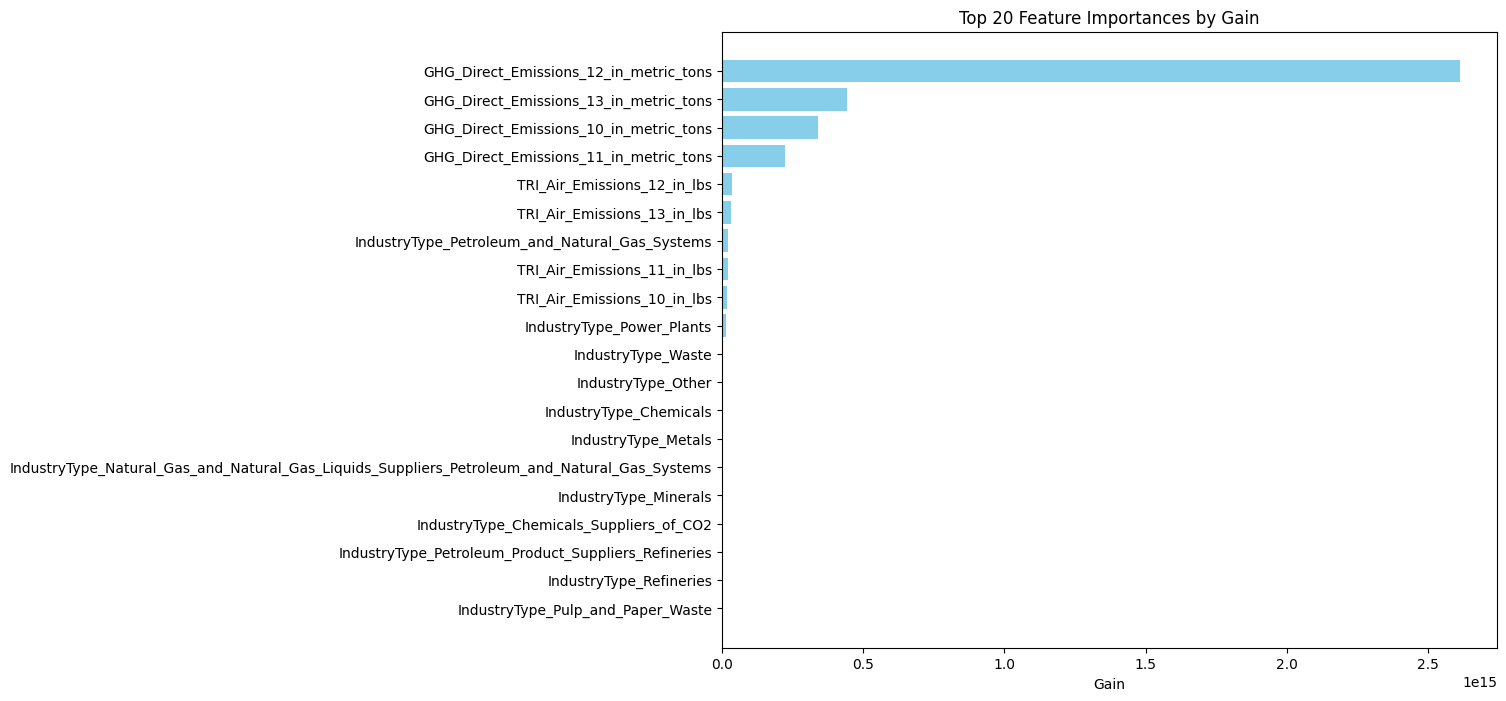

In [284]:
# 'gain'を基準とした特徴量重要度を取得
importance_gain = model.feature_importance(importance_type='gain')
# 'split'を基準とした特徴量重要度を取得
importance_split = model.feature_importance(importance_type='split')

# 特徴量名の取得
feature_names = model.feature_name()
# Gainに基づく特徴量重要度のデータフレーム
df_gain = pd.DataFrame({
    'feature': feature_names,
    'importance_gain': importance_gain
}).sort_values(by='importance_gain', ascending=False)

# Splitに基づく特徴量重要度のデータフレーム
df_split = pd.DataFrame({
    'feature': feature_names,
    'importance_split': importance_split
}).sort_values(by='importance_split', ascending=False)
plt.figure(figsize=(10, 8))
plt.barh(df_gain['feature'][:20][::-1], df_gain['importance_gain'][:20][::-1], color='skyblue')
plt.xlabel('Gain')
plt.title('Top 20 Feature Importances by Gain')
plt.show()

評価結果（モデルの精度）が出力されました。<br>
初めて参加される方は、是非この値を超えるようなモデルの作成を目指してください！

# 4. 予測・結果の投稿
最後に学習したモデルをテストデータに対して予測をし、投稿ファイルを作成します。

In [285]:
test_X.columns, test_X.shape

(Index(['TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
        'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
        'GHG_Direct_Emissions_10_in_metric_tons',
        'GHG_Direct_Emissions_11_in_metric_tons',
        'GHG_Direct_Emissions_12_in_metric_tons',
        'GHG_Direct_Emissions_13_in_metric_tons', 'IndustryType_Chemicals',
        'IndustryType_Chemicals_Industrial_Gas_Suppliers',
        'IndustryType_Chemicals_Petroleum_Product_Suppliers_Refineries',
        'IndustryType_Chemicals_Suppliers_of_CO2',
        'IndustryType_Chemicals_Waste', 'IndustryType_Metals',
        'IndustryType_Metals_Waste', 'IndustryType_Minerals',
        'IndustryType_Minerals_Waste',
        'IndustryType_Natural_Gas_and_Natural_Gas_Liquids_Suppliers_Petroleum_and_Natural_Gas_Systems',
        'IndustryType_Other', 'IndustryType_Other_Suppliers_of_CO2',
        'IndustryType_Other_Suppliers_of_CO2_Waste', 'IndustryType_Other_Waste',
        'IndustryType_Petroleum_P

In [286]:
test_pred = model.predict(test_X)
test_pred

array([  79298.22534349,  363357.08332825,   48242.8109525 , ...,
        213817.47468352,  195255.05391199, 1029986.88286976])

テストデータの予測ができました。<br>
見本のsample_submission.csvを用いて投稿ファイルを作成しましょう。

In [287]:
file_name = "1_SMBC.scv"
# 投稿ファイル作成
submit = pd.read_csv(path+"sample_submission.csv", header=None)
submit[1] = test_pred
submit.to_csv(file_name, header=None, index=False)

In [288]:
# 投稿ファイルの中身を確認
submit.head()

,0,1
0,4655,79298.225343
1,4656,363357.083328
2,4657,48242.810953
3,4658,24683.683020
4,4659,79068.723648


これで本チュートリアルは終了です。<br>
早速作成したsubmission_tutorial.csvを投稿してみましょう。<br>
コンペサイトの投稿ボタンから投稿可能です。

# 5. 精度改善のヒント
<p>投稿が完了しましたが、コンペティションはこれで終わりではありません。次に精度を改善する必要があります。<br>
ぜひチャレンジしてみてください。

今後の改善点の例：
- 他の特徴量から、新たな特徴量を作成する
- 欠損値を別の方法で埋める
- LightGBM以外のアルゴリズムや、アンサンブル（複数のモデルの予測結果の平均などを取る処理）を行う